# Arxiv Title Generation

In [1]:
# !pip install youtokentome

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import joblib
import pandas as pd
import numpy as np
import youtokentome as yttm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm

import spacy

import collections
import copy
import random
import math
import time
import gc

import heapq

def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
    
init_random_seed(1234)

In [3]:
try: 
    from pip._internal.operations import freeze
except ImportError: # pip < 10.0
    from pip.operations import freeze

pkgs = freeze.freeze()
for pkg in pkgs:
    print(pkg)

D:\Dev\jupyter\projects\Data Science\ds_stuff\Different courses\Нейронные сети и обработка текста\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


asttokens==2.2.1
backcall==0.2.0
blis==0.7.9
bokeh==3.0.3
catalogue==2.0.8
certifi==2022.12.7
charset-normalizer==2.1.1
click==8.1.3
colorama==0.4.6
comm==0.1.2
confection==0.0.3
contourpy==1.0.6
cycler==0.11.0
cymem==2.0.7
Cython==0.29.32
DAWG-Python==0.7.2
debugpy==1.6.4
decorator==5.1.1
docopt==0.6.2
entrypoints==0.4
executing==1.2.0
fonttools==4.38.0
gensim==3.8.1
idna==3.4
intervaltree==3.1.0
ipykernel==6.19.4
ipymarkup==0.9.0
ipython==8.7.0
ipywidgets==8.0.3
jedi==0.18.2
Jinja2==3.1.2
joblib==1.2.0
jupyter_client==7.4.8
jupyter_core==5.1.0
jupyterlab-widgets==3.0.4
kiwisolver==1.4.4
langcodes==3.3.0
livelossplot==0.5.3
lxml==4.9.2
MarkupSafe==2.1.1
matplotlib==3.6.2
matplotlib-inline==0.1.6
murmurhash==1.0.9
nest-asyncio==1.5.6
nltk==3.8
numpy==1.24.0
packaging==22.0
pandas==1.5.2
parso==0.8.3
pathy==0.10.1
pickleshare==0.7.5
Pillow==9.3.0
pip==22.3.1
platformdirs==2.6.0
preshed==3.0.8
prompt-toolkit==3.0.36
psutil==5.9.4
pure-eval==0.2.2
pyconll==3.1.0
pydantic==1.10.2
Pygments=

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Data

In [5]:
DATA_PATH = './data'

In [6]:
data = pd.read_csv(f'{DATA_PATH}/train.csv')
print(data.shape)
data.head()

(135000, 2)


,abstract,title
0,we consider the problem of utility maximizatio...,on optimal investment with processes of long o...
1,in this paper we provide an explicit formula f...,boolean complexes for ferrers graphs
2,"kinesin-5, also known as eg5 in vertebrates is...",relative velocity of sliding of microtubules b...
3,we discuss the transition paths in a coupled b...,bifurcation of transition paths induced by cou...
4,two types of room temperature detectors of ter...,all-electric detectors of the polarization sta...


In [7]:
data = data[~(data['abstract'].apply(len) <= data['title'].apply(len))].reset_index(drop=True)
data.shape

(134827, 2)

In [8]:
data = data.drop_duplicates().reset_index(drop=True)
data.shape

(105463, 2)

In [9]:
data = data.drop_duplicates('abstract').reset_index(drop=True)
data.shape

(105402, 2)

In [10]:
data = data.drop_duplicates('title').reset_index(drop=True)
data.shape

(105331, 2)

In [11]:
data = data[~(data['abstract'].apply(lambda x: 'withdrawn' in x.lower()))].reset_index(drop=True)
data.shape

(105209, 2)

In [12]:
data.sample(5)

,abstract,title
31660,we consider evaluating improper priors in a fo...,evaluating default priors with a generalizatio...
86648,we characterize the gorenstein nilpotent schem...,gorenstein multiple structures on smooth algeb...
50463,we show that the glauber dynamics on proper 9-...,sampling colourings of the triangular lattice
19251,we study the effect of disorder on the order p...,effect of disorder on a pomeranchuk instability
44100,we determine the z-module structure of the pre...,zeroth hochschild homology of preprojective al...


In [13]:
data = data[~(data['title'].apply(lambda x: len(x.split(' '))) == 1)].reset_index(drop=True)
data.shape

(105176, 2)

In [14]:
data = data[~(data['abstract'].apply(lambda x: 'no abstract' in x))].reset_index(drop=True)
data.shape

(105170, 2)

In [15]:
%%time
title_sets = data['title'].apply(lambda x: set(x.split(' ')))
abstract_sets = data['abstract'].apply(lambda x: set(x.split(' ')))

idxs = []
for i, title_set in title_sets.items():
    if i and len(title_set.intersection(abstract_sets[i])) == 0:
        print(i)
        idxs.append(i)

101
171
505
818
1058
1275
1468
1619
1741
2599
2719
2865
3174
3395
3679
3711
4302
4541
4730
5766
5794
5817
5852
6075
6528
6626
6646
6922
6937
7024
7183
7533
7624
8238
8316
8592
8640
8887
9512
9668
9910
10118
10779
11031
11062
11137
11263
11329
11400
11823
11916
11962
12337
12420
12450
13049
13374
13460
13719
13777
13916
13964
14258
15203
15463
15534
15614
16224
16909
16977
17075
17082
17614
17785
17957
18108
18289
19028
19090
19444
20014
20130
20279
20421
20466
20578
20754
20812
20945
21405
22031
22044
22294
22462
22571
22675
22932
23177
23178
23525
23660
23699
23884
24094
24279
24773
24891
24905
24911
24922
25719
25828
26099
26258
26314
26667
26979
27244
27332
27703
27881
28280
28384
28903
28959
29004
29016
29352
29408
29650
29674
30096
30188
30608
30815
30841
31087
31106
31210
31553
31656
31858
32323
32523
32697
33423
33445
33786
33990
34082
34122
34574
34831
34952
35696
35831
35887
36168
36305
36459
36788
37038
37071
37248
37781
38053
38248
38374
38682
38854
38914
39309
39674
40120
4

In [16]:
data.iloc[79888].abstract

'consider any dirichlet series sum a_n/n^z with nonnegative coefficients a_n and finite sum function f(z)=f(x+iy) when x is greater than 1. denoting the partial sum a_1+...+a_n by s_n, the paper gives the following necessary and sufficient condition in order that (s_n)/n remain bounded as n goes to infinity. for x tending to 1 from above, the quotient q(x+iy)=f(x+iy)/(x+iy) must converge to a pseudomeasure q(1+iy), the distributional fourier transform of a bounded function. the paper also gives an optimal estimate for (s_n)/n under the "real condition" that (1-x)f(x) remain bounded as x tends to 1 from above.'

In [17]:
data.iloc[79888].title

'ikehara-type theorem involving boundedness'

In [18]:
data = data.drop(idxs).reset_index(drop=True)
data.shape

(104650, 2)

# Train-Test split

In [19]:
init_random_seed(1234)

val_ratio = 0.01
test_ratio = 0.01

val_idx = np.random.choice(a=len(data), size=int(len(data)*(val_ratio+test_ratio)), replace=False)

train_data = data.drop(val_idx).copy()
val_data = data.iloc[val_idx[:len(val_idx)//2]].copy()
test_data = data.iloc[val_idx[len(val_idx)//2:]].copy()

In [20]:
val_idx

array([73167, 15633, 74851, ..., 67085, 59049, 16476])

In [21]:
# check if there's no intersection among sets
print(set(train_data.index).intersection(set(val_data.index)))
print(set(train_data.index).intersection(set(test_data.index)))
print(set(val_data.index).intersection(set(test_data.index)))

set()
set()
set()


In [22]:
train_data.values[0][0], train_data.values[0][1]

('we consider the problem of utility maximization for investors with power utility functions. building on the earlier work larsen et al. (2016), we prove that the value of the problem is a frechet-differentiable function of the drift of the price process, provided that this drift lies in a suitable banach space.   we then study optimal investment problems with non-markovian driving processes. in such models there is no hope to get a formula for the achievable maximal utility. applying results of the first part of the paper we provide first order expansions for certain problems involving fractional brownian motion either in the drift or in the volatility. we also point out how asymptotic results can be derived for models with strong mean reversion.',
 'on optimal investment with processes of long or negative memory')

In [23]:
test_data.values[0]

array(["we present a feature engineering pipeline for the construction of musical signal characteristics, to be used for the design of a supervised model for musical genre identification. the key idea is to extend the traditional two-step process of extraction and classification with additive stand-alone phases which are no longer organized in a waterfall scheme. the whole system is realized by traversing backtrack arrows and cycles between various stages. in order to give a compact and effective representation of the features, the standard early temporal integration is combined with other selection and extraction phases: on the one hand, the selection of the most meaningful characteristics based on information gain, and on the other hand, the inclusion of the nonlinear correlation between this subset of features, determined by an autoencoder. the results of the experiments conducted on gtzan dataset reveal a noticeable contribution of this methodology towards the model's performance i

In [24]:
# %%time
# with open(f'{DATA_PATH}/data.txt', "w") as fout:
#     for i, row in train_data.iterrows():
#         print(row['abstract'] + '\n' + row['title'], file=fout)

In [25]:
MODELS_PATH = './models'

BPE_MODEL_FILENAME = f'{MODELS_PATH}/bpe.yttm'
TRAIN_TEXTS_FILENAME = f'{DATA_PATH}/data.txt'

yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=2000, model=BPE_MODEL_FILENAME);

In [26]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

In [27]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ e t i a o n s r l c h d m p u f g y b w v . , - k x $ q ) ( z \ 0 1 2 j } { _ ' 3 : ^ 5 / 4 " 9 6 = 8 7 + ; % [ ] ` > < | ~ * ? & ! # @  ▁t ▁a in on ▁th ti er ▁the ▁s re ▁o en ▁c al ▁p or es tion ▁of at is ▁f ▁m ▁in ▁w ▁d ed it ar an ro ▁an ing ▁b ic le ation ▁e ▁and et el ▁re as ▁to ▁n ent im om ul ct us ▁h od ▁l ▁pro ▁g ▁for ▁we un ▁is ▁st ▁con ra ce ly ch ve st si ur ol tic ith ▁on ow qu am ri ▁ex ▁that il ▁with ity ▁v res ut em s. ▁as ▁mod ction ▁com ▁al per ate um ▁wh ter ig os ab id ver ot pl ▁( if ▁be ▁model ▁are ▁sp ▁this ▁de ge ▁su ▁comp ▁r ▁by iz ect ▁dis ir ▁us ure ▁$ ical s, se ▁ap und tim ati ces orm ▁sh th ▁res di ▁ma ations ▁ne og ▁se ence ari ▁ch ution ts sion oc etw rom pro ff ▁par ▁co ated ork ment ain ▁met ich ▁it ▁im ble ant ener op ore form ▁from ▁cl fer ▁sy and ine du ▁dat ▁or ▁which ▁can ▁le ru ere igh ▁at ▁es ec rib ud act vel tical ran ▁meth ▁ob ▁me ▁method es. end ▁k te ple ell ric ▁inter ▁qu ▁data ance der ous ▁show ▁un ▁per ▁ac ay 

In [28]:
encoded_sample = tokenizer.encode(test_data['title'].values[0])
print(encoded_sample)

[1108, 100, 88, 537, 114, 249, 130, 315, 119, 873, 1725, 521, 21, 249, 80, 106, 97, 96, 124, 108, 1017, 83, 1996, 1301]


In [29]:
print(tokenizer.decode(encoded_sample))
del encoded_sample
gc.collect()

['extended pipeline for content-based feature engineering in music genre recognition']


0

In [30]:
tokenizer.subword_to_id('<UNK>')

1

In [31]:
val_token_abstract = tokenizer.encode(val_data['abstract'].values.tolist(), bos=True, eos=True)

unknown_subwords_in_test = sum(1 for text in val_token_abstract for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


In [32]:
test_token_abstract = tokenizer.encode(test_data['abstract'].values.tolist(), bos=True, eos=True)

unknown_subwords_in_test = sum(1 for text in test_token_abstract for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в тестовой выборке',
      unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в тестовой выборке 0


In [33]:
# spacy_en = spacy.load('en_core_web_sm')
# def tokenize_spacy(text):
#     """
#     Tokenizes English text from a string into a list of strings (tokens)
#     """
#     return [tok.text for tok in spacy_en.tokenizer(text) if not tok.text.isspace()]

# Building vocabulary

In [34]:
# def build_vocabulary(
#     tokenized_texts,
#     max_size=1000000,
#     max_doc_freq=0.8,
#     min_count=5,
#     pad_word=None,
#     unk_word=None,
#     sos_word=None,
#     eos_word=None
# ):
#     word_counts = collections.defaultdict(int)
#     doc_n = 0

#     # посчитать количество документов, в которых употребляется каждое слово
#     # а также общее количество документов
#     for txt in tokenized_texts:
#         doc_n += 1
#         unique_text_tokens = set(txt)
#         for token in unique_text_tokens:
#             word_counts[token] += 1

#     # убрать слишком редкие и слишком частые слова
#     word_counts = {word: cnt for word, cnt in word_counts.items()
#                    if cnt >= min_count and cnt / doc_n <= max_doc_freq}

#     # отсортировать слова по убыванию частоты
#     sorted_word_counts = sorted(word_counts.items(),
#                                 reverse=True,
#                                 key=lambda pair: pair[1])
#     if unk_word is not None:
#         sorted_word_counts = [(unk_word, 0)] + sorted_word_counts
    
#     # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
#     if pad_word is not None:
#         sorted_word_counts = [(pad_word, 0)] + sorted_word_counts
        
#     if sos_word is not None:
#         sorted_word_counts = [(sos_word, 0)] + sorted_word_counts
        
#     if eos_word is not None:
#         sorted_word_counts = [(eos_word, 0)] + sorted_word_counts

#     # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
#     if len(word_counts) > max_size:
#         sorted_word_counts = sorted_word_counts[:max_size]

#     # нумеруем слова
#     word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

#     # нормируем частоты слов
#     word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

#     return word2id, word2freq

In [35]:
# %%time
# train_tokenized = [
#     tokenize(sentence) for sentence in (train_data['abstract'] + ' ' + train_data['title'])
# ]

In [36]:
# %%time
# vocabulary, _ = build_vocabulary(
#     train_tokenized,
#     max_doc_freq=1,
#     min_count=3,
#     pad_word='<PAD>',
#     unk_word='<UNK>',
#     sos_word='<SOS>',
#     eos_word='<EOS>'
# )

# print(len(vocabulary))
# del train_tokenized, data
# gc.collect()

## Sorting texts by their length

In [37]:
# train_data['len_abstract'] = train_data['abstract'].apply(len)
# train_data['len_title'] = train_data['title'].apply(len)
# train_data = train_data.sort_values(['len_abstract', 'len_title'], ascending=False)

# val_data['len_abstract'] = val_data['abstract'].apply(len)
# val_data['len_title'] = val_data['title'].apply(len)
# val_data = val_data.sort_values(['len_abstract', 'len_title'], ascending=False)

# test_data['len_abstract'] = test_data['abstract'].apply(len)
# test_data['len_title'] = test_data['title'].apply(len)
# test_data = test_data.sort_values(['len_abstract', 'len_title'], ascending=False)

In [38]:
%%time
train_data['len_abstract'] = list(map(len, tokenizer.encode(train_data['abstract'].values.tolist())))
train_data['len_title'] = list(map(len, tokenizer.encode(train_data['title'].values.tolist())))
train_data = train_data.sort_values(['len_abstract', 'len_title'], ascending=False)

val_data['len_abstract'] = list(map(len, tokenizer.encode(val_data['abstract'].values.tolist())))
val_data['len_title'] = list(map(len, tokenizer.encode(val_data['title'].values.tolist())))
val_data = val_data.sort_values(['len_abstract', 'len_title'], ascending=False)

test_data['len_abstract'] = list(map(len, tokenizer.encode(test_data['abstract'].values.tolist())))
test_data['len_title'] = list(map(len, tokenizer.encode(test_data['title'].values.tolist())))
test_data = test_data.sort_values(['len_abstract', 'len_title'], ascending=False)

CPU times: total: 29.6 s
Wall time: 4.25 s


In [39]:
train_data['len_abstract'].max(), train_data['len_title'].max()

(1380, 124)

In [40]:
train_data['len_abstract'].min(), train_data['len_title'].min()

(8, 2)

In [41]:
# class ArxivDataset(torch.utils.data.Dataset):
#     def __init__(self,
#                  src,
#                  trg,
#                  tokenizer,
#                  vocabulary,
#                  unk_word='<UNK>',
#                  pad_word='<PAD>',
#                  sos_word='<SOS>',
#                  eos_word='<EOS>'
#                 ):
#         self.tokenizer = tokenizer
#         self.word2id = vocabulary
#         self.unk_word = unk_word
#         self.pad_word = pad_word
#         self.sos_word = sos_word
#         self.eos_word = eos_word
        
#         # сразу токенизируем слова
#         self.src = [self.tokenizer(sentence) for sentence in src]
#         self.trg = [self.tokenizer(sentence) for sentence in trg]
        
#     def __len__(self):
#         return len(self.src)
    
#     def __getitem__(self, i):
#         # добавляем токены начала и конца предложения
#         src_i = [self.sos_word] + self.src[i] + [self.eos_word]
#         trg_i = [self.sos_word] + self.trg[i] + [self.eos_word]
        
#         # переводим токены в их номера из словаря, при этом незнакомые токены переводим в неизвестный токен
#         src_num = [self.word2id.get(word, self.word2id[self.unk_word]) for word in src_i]
#         trg_num = [self.word2id.get(word, self.word2id[self.unk_word]) for word in trg_i]
        
#         return src_num, trg_num

In [42]:
class ArxivDataset(torch.utils.data.Dataset):
    def __init__(self,
                 src,
                 trg,
                 tokenizer,
                 unk_word='<UNK>',
                 pad_word='<PAD>',
                 sos_word='<BOS>',
                 eos_word='<EOS>'
                ):
        self.tokenizer = tokenizer
        self.unk_word = unk_word
        self.pad_word = pad_word
        self.sos_word = sos_word
        self.eos_word = eos_word
        
        # сразу кодируем слова
        self.src = self.tokenizer.encode(src)
        self.trg = self.tokenizer.encode(trg)
        
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, i):
        # добавляем токены начала и конца предложения
        src_i = [self.tokenizer.subword_to_id(self.sos_word)] + self.src[i]\
        + [self.tokenizer.subword_to_id(self.eos_word)]
        trg_i = [self.tokenizer.subword_to_id(self.sos_word)] + self.trg[i]\
        + [self.tokenizer.subword_to_id(self.eos_word)]
        
        return src_i, trg_i

In [43]:
%%time
arx_dataset_train = ArxivDataset(
    train_data['abstract'].values.tolist(),
    train_data['title'].values.tolist(),
    tokenizer
)
arx_dataset_val = ArxivDataset(
    val_data['abstract'].values.tolist(),
    val_data['title'].values.tolist(),
    tokenizer
)
arx_dataset_test = ArxivDataset(
    test_data['abstract'].values.tolist(),
    test_data['title'].values.tolist(),
    tokenizer
)

CPU times: total: 25.8 s
Wall time: 4.72 s


In [44]:
print(arx_dataset_train[1])

([2, 763, 9, 30, 854, 865, 123, 338, 1337, 89, 33, 133, 105, 594, 1001, 153, 86, 93, 87, 22, 35, 90, 81, 865, 164, 92, 763, 9, 30, 854, 117, 1269, 125, 34, 39, 33, 9, 34, 39, 614, 774, 1189, 81, 1532, 110, 92, 81, 129, 1268, 50, 56, 115, 142, 250, 5, 733, 166, 103, 249, 179, 5, 50, 56, 8, 33, 97, 81, 288, 304, 82, 458, 92, 82, 89, 244, 400, 122, 20, 9, 102, 14, 122, 124, 107, 8, 102, 142, 7, 478, 795, 100, 81, 134, 1128, 395, 92, 105, 4, 1255, 28, 167, 9, 30, 9, 1844, 557, 280, 108, 29, 138, 115, 264, 100, 155, 125, 34, 39, 33, 9, 34, 39, 33, 1427, 1218, 1140, 44, 5, 41, 1740, 166, 26, 1387, 709, 39, 33, 576, 26, 652, 26, 219, 160, 26, 82, 223, 26, 451, 39, 50, 27, 1382, 52, 53, 53, 28, 50, 52, 53, 56, 61, 26, 117, 967, 1331, 185, 584, 15, 160, 5, 287, 9, 30, 1234, 1255, 1844, 27, 131, 431, 897, 151, 100, 549, 75, 96, 1140, 51, 9, 41, 11, 11, 23, 1150, 80, 485, 92, 81, 179, 48, 56, 33, 20, 5, 28, 85, 12, 235, 100, 111, 50, 56, 8, 82, 89, 244, 99, 26, 107, 8, 102, 142, 7, 115, 264, 100,

In [45]:
class BatchSizeDataloader:
    def __init__(self, dataset, batch_size, pad_value, device, batch_first=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dataset_len = len(dataset)
        self.pad_value = pad_value
        self.batch_first = batch_first
        self.device = device
        
        # для создания итератора
        self.num = 0
        
    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))
    
    def __iter__(self):
        return self
    
    @staticmethod
    def ensure_length(txt: list, out_len: int, pad_value: int):
        """
        Функция для добавления фиктивных токенов в преложение вида [23, 43, 121]
        """
        if len(txt) < out_len:
            txt = list(txt) + [pad_value] * (out_len - len(txt))
        else:
            txt = txt[:out_len]
        return txt
    
    def __next__(self):
        if self.num >= self.__len__():
            # если итерирование закончено, то выставить счетчик снова в 0
            self.num = 0
            raise StopIteration
            
        src = []
        src_len = []
        trg = []
        trg_len = []
        for i in range(self.num*self.batch_size, (self.num+1)*self.batch_size):
            if i >= self.dataset_len:
                break
                
            src_i, trg_i = self.dataset[i]
            src.append(src_i)
            src_len.append(len(src_i))
            
            trg.append(trg_i)
            trg_len.append(len(trg_i))
            
        max_len_src = np.max(src_len)
        max_len_trg = np.max(trg_len)
        
        ensured_src = []
        ensured_trg = []
        for i in range(len(src)):
            src_i = src[i]
            trg_i = trg[i]
            
            ensured_src.append(self.ensure_length(src_i, max_len_src, self.pad_value))
            ensured_trg.append(self.ensure_length(trg_i, max_len_trg, self.pad_value))

        self.num += 1
        
        ensured_src = torch.LongTensor(ensured_src)
        src_len = torch.LongTensor(src_len)
        ensured_trg = torch.LongTensor(ensured_trg)
        trg_len = torch.LongTensor(trg_len)
        
        if not self.batch_first:
            ensured_src = ensured_src.permute(1, 0)
            ensured_trg = ensured_trg.permute(1, 0)
        
        return ensured_src.to(self.device), src_len.to(self.device),\
                ensured_trg.to(self.device), trg_len.to(self.device)

In [46]:
# PAD_IDX = vocabulary['<PAD>']
PAD_IDX = tokenizer.subword_to_id('<PAD>')

train_data_loader = BatchSizeDataloader(arx_dataset_train, batch_size=32, device=device, pad_value=PAD_IDX)
# val_data_loader = BatchSizeDataloader(arx_dataset_val, batch_size=32, device=device, pad_value=PAD_IDX)
# test_data_loader = BatchSizeDataloader(arx_dataset_test, batch_size=32, device=device, pad_value=PAD_IDX)

In [47]:
j = 0
for src, src_len, trg, trg_len in train_data_loader:
    print(src)
    print(src_len)
    j += 1
    if j == 3:
        break
        
del train_data_loader#, val_data_loader, test_data_loader
gc.collect()
torch.cuda.empty_cache()

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [ 127,  763,  350,  ..., 1995,  185,  748],
        [  44,    9, 1744,  ...,  444,  413,   11],
        ...,
        [1004,    0,    0,  ...,    0,    0,    0],
        [ 509,    0,    0,  ...,    0,    0,    0],
        [   3,    0,    0,  ...,    0,    0,    0]], device='cuda:0')
tensor([1382, 1129, 1110, 1109,  939,  908,  864,  839,  837,  802,  797,  788,
         787,  784,  778,  769,  769,  767,  766,  760,  757,  745,  739,  739,
         734,  732,  730,  730,  728,  727,  725,  723], device='cuda:0')
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [  81,   81,   97,  ...,    4,  130,   75],
        [ 930,  115,  107,  ..., 1157,  868,  326],
        ...,
        [  16,   26,    0,  ...,    0,    0,    0],
        [  26,    3,    0,  ...,    0,    0,    0],
        [   3,    0,    0,  ...,    0,    0,    0]], device='cuda:0')
tensor([720, 719, 715, 715, 712, 711, 709, 707, 707, 706, 702, 701, 701, 701,
  

# Modeling

In [48]:
def make_positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]
    
    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result

In [49]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        self.hid_dim = hid_dim
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
#         self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
#         pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
#         src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
    
        pos_codes = make_positional_encoding(src_len,
                                             self.hid_dim).unsqueeze(0).to(self.device)

        src = self.dropout((self.tok_embedding(src) * self.scale) + pos_codes.repeat(batch_size, 1, 1))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [50]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [51]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim=-1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [52]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [53]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        self.hid_dim = hid_dim
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
#         self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
#         pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
#         trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        pos_codes = make_positional_encoding(trg_len,
                                             self.hid_dim).unsqueeze(0).to(self.device)
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + pos_codes)
        
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [54]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [55]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [56]:
train_data

,abstract,title,len_abstract,len_title
39856,l'analyse du lien entre l'environnement et la ...,construction d'une plate-forme int\'egr\'ee po...,1380,55
73288,superoxide reductase (sor) is an fe protein th...,"m{\""o}ssbauer characterization of an unusual h...",1127,69
1340,phylogenetic approaches are finding more and m...,clustering with phylogenetic tools in astrophy...,1108,15
70669,"this article, in english, represents part of t...",ettore majorana's scientific (and human) perso...,1107,21
81882,background: there is uncertainty about the bur...,pediatric hospitalizations associated with res...,937,52
...,...,...,...,...
45245,we determine the fundamental group of period d...,the fundamental group of period domains over f...,13,10
80674,methods of particle beam cooling are reviewed.,cooling of particle beams in storage rings,12,14
82834,computations in the cohomology of finite groups.,the cohomology of certain groups,12,8
35605,a simple application of the semipositivity.,a product formula for volumes of varieties,11,12


In [57]:
# INPUT_DIM = len(vocabulary)
# OUTPUT_DIM = len(vocabulary)
INPUT_DIM = tokenizer.vocab_size()
OUTPUT_DIM = tokenizer.vocab_size()
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 64
DEC_PF_DIM = 64
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# SOS_IDX = vocabulary['<SOS>']
# EOS_IDX = vocabulary['<EOS>']
SOS_IDX = tokenizer.subword_to_id('<BOS>')
EOS_IDX = tokenizer.subword_to_id('<EOS>')

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device
             )

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device
             )

model = Seq2Seq(enc, dec, PAD_IDX, PAD_IDX, device).to(device)

In [58]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
            
model.apply(initialize_weights)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' not in name:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(2000, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=64, bias=True)
          (fc_2): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)

In [59]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,112,720 trainable parameters


In [69]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.000125)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_sched = None

In [70]:
def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=3,
                                                      factor=0.5,
                                                      verbose=True)

lr_sched = lr_scheduler(optimizer)

In [71]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = []
    
    for i, batch in enumerate(iterator):
        
        src, src_len, trg, trg_len = batch
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)

In [72]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len, trg, trg_len = batch

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [73]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [74]:
MODEL_NAME = f'{MODELS_PATH}/transformer_yttm.pt'

In [78]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[-0.0385,  0.0327,  0.0045,  ..., -0.0504,  0.0197, -0.0298],
           [-0.0212,  0.0395, -0.0206,  ..., -0.0253,  0.0327, -0.0048],
           [ 0.0546, -0.0462,  0.2006,  ..., -0.0297, -0.2753, -0.0328],
           ...,
           [ 0.8339,  0.3079,  0.2088,  ..., -0.8094, -0.5149,  0.0926],
           [ 0.0436,  0.1904,  0.2077,  ..., -0.0054, -0.1352,  0.1382],
           [ 0.0058,  0.0880, -0.2132,  ...,  0.0171, -0.2079,  0.0700]],
          device='cuda:0', requires_grad=True),
   Parameter containing:
   tensor([0.8924, 0.3829, 1.0946, 0.9791, 1.3326, 1.2822, 0.9896, 0.7459, 0.9788,
           1.3791, 1.3874, 0.9081, 1.4637, 1.1194, 0.8420, 1.1368, 1.0967, 1.0298,
           0.9009, 1.1566, 0.6937, 0.9528, 1.2975, 1.3079, 0.8076, 1.4147, 1.3848,
           1.1110, 1.4756, 0.9886, 0.9951, 1.1572, 1.2136, 0.8950, 0.7774, 1.9902,
           1.1649, 0.6979, 1.0144, 0.6275, 1.6930, 1.2363, 1.0165, 0.5246, 0.7331,
           1.4817, 0.8

In [76]:
# transformer1 2 раза сократился lr до 0.000125, при продолжении обучения выставить его таким

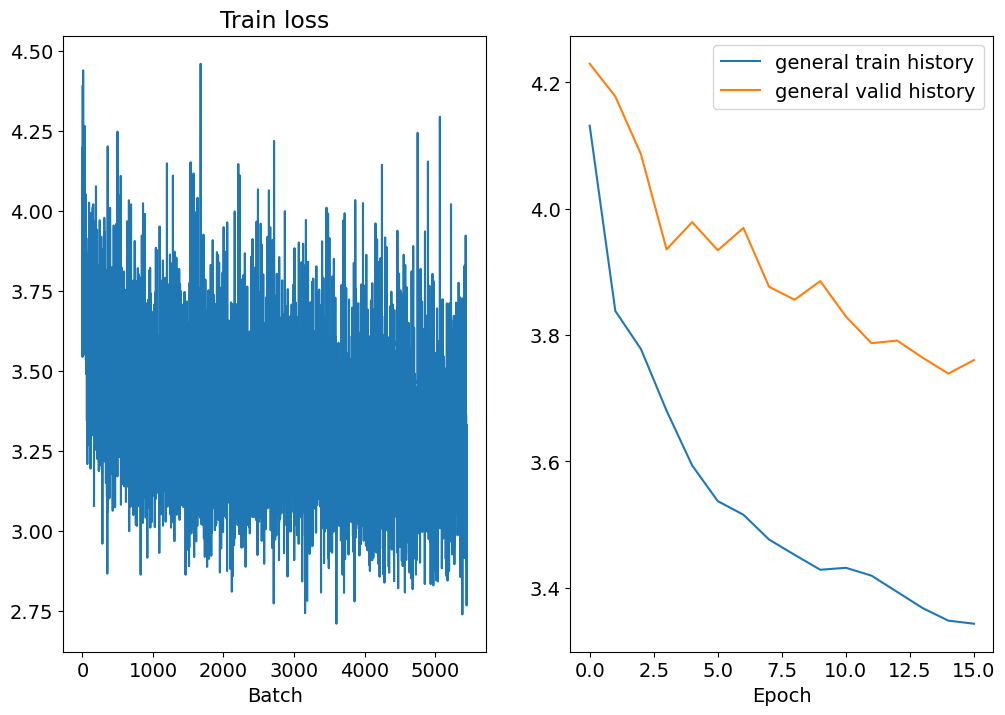

KeyboardInterrupt: 

In [77]:
# model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cuda')))
# model.load_state_dict(torch.load(f'{MODELS_PATH}/transformer_yttm_100_more_cleaning.pt', map_location=torch.device('cuda')))
torch.cuda.empty_cache()

N_EPOCHS = 100
CLIP = 1

train_data_loader = BatchSizeDataloader(
    arx_dataset_train, batch_size=16, device=device, batch_first=True, pad_value=PAD_IDX)

val_data_loader = BatchSizeDataloader(
    arx_dataset_val, batch_size=16, device=device, batch_first=True, pad_value=PAD_IDX)

# test_data_loader = BatchSizeDataloader(
#     arx_dataset_test, batch_size=32, device=device, batch_first=True, pad_value=PAD_IDX)

train_history = []
valid_history = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_data_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, val_data_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)
        
    if lr_sched is not None:
        lr_sched.step(valid_loss)
        
        
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# del test_data_loader
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
# for cpu usage
model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cuda')))

test_data_loader = BatchSizeDataloader(
    arx_dataset_test, batch_size=32, device=device, batch_first=True, pad_value=PAD_IDX)
test_loss = evaluate(model, test_data_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

# Generating

In [ ]:
# id2word = {value: key for key, value in vocabulary.items()}
# id2word[0]

In [ ]:
# def translate_sentence(sentence, word2id, id2word, model, device, max_len = 50):
    
#     model.eval()
#     src_tensor = torch.LongTensor(sentence).unsqueeze(0).to(device)
    
#     src_mask = model.make_src_mask(src_tensor)
    
#     with torch.no_grad():
#         enc_src = model.encoder(src_tensor, src_mask)

#     trg_indexes = [word2id['<SOS>']]

#     for i in range(max_len):

#         trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

#         trg_mask = model.make_trg_mask(trg_tensor)
        
#         with torch.no_grad():
#             output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

#         pred_token = output.argmax(2)[:,-1].item()
        
#         trg_indexes.append(pred_token)

#         if pred_token == word2id['<EOS>']:
#             break
    
#     trg_tokens = [id2word[i] for i in trg_indexes]
    
#     return trg_tokens[1:], attention

# def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
#     assert n_rows * n_cols == n_heads
    
#     fig = plt.figure(figsize=(15,25))
    
#     for i in range(n_heads):
        
#         ax = fig.add_subplot(n_rows, n_cols, i+1)
        
#         _attention = attention.squeeze(0)[i].cpu().detach().numpy()

#         cax = ax.matshow(_attention, cmap='bone')

#         ax.tick_params(labelsize=12)
#         ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
#                            rotation=90)
#         ax.set_yticklabels(['']+translation)

#         ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#         ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()
#     plt.close()

In [ ]:
def translate_sentence(sentence, tokenizer, model, device, max_len = 50):
    
    model.eval()
    src_tensor = torch.LongTensor(sentence).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [tokenizer.subword_to_id('<BOS>')]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == tokenizer.subword_to_id('<EOS>'):
            break
    
    trg_tokens = tokenizer.decode(trg_indexes)

    return trg_tokens, attention

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=90)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 100000

src, trg = arx_dataset_train[example_idx]

print(f'src = {src}')
print(f'trg = {trg}')

In [ ]:
translation, attention = translate_sentence(
    model=model,
    tokenizer=tokenizer,
    sentence=src,
    device=device,
)

print(f'predicted trg = {translation}')
print(f'true trg = {tokenizer.decode(trg)}')

In [ ]:
# translation, attention = translate_sentence(
#     model=model,
#     sentence=src,
#     device=device,
#     word2id=vocabulary,
#     id2word=id2word
# )

# print(f'predicted trg = {translation}')
# print(f'true trg = {[id2word[word] for word in trg]}')

In [ ]:
# display_attention([id2word[word] for word in src], translation, attention)

In [ ]:
# for example_idx in range(100):
#     src, trg = arx_dataset_test[example_idx]
# #     src = [id2word[word] for word in src]
#     trg = [id2word[word] for word in trg]
#     translation, attention = translate_sentence(
#         model=model,
#         sentence=src,
#         device=device,
#         word2id=vocabulary,
#         id2word=id2word)

#     print('Оригинальный заголовок: ', ' '.join(trg))
#     print('Предсказанный заголовок: ', ' '.join(translation))
#     print('-----------------------------------')

In [ ]:
for example_idx in range(100):
    src, trg = arx_dataset_test[example_idx]
#     src = [id2word[word] for word in src]
    trg = tokenizer.decode(trg)
    translation, attention = translate_sentence(
        model=model,
        tokenizer=tokenizer,
        sentence=src,
        device=device,
    )

    print('Оригинальный заголовок: ', ' '.join(trg))
    print('Предсказанный заголовок: ', ' '.join(translation))
    print('-----------------------------------')

In [ ]:
# class BeamGenerator:
#     def __init__(self, model, word2id, id2word, device, eos_token_id):
#         self.model = model
#         self.word2id = word2id
#         self.id2word = id2word
#         self.device = device
#         self.model.to(self.device)
#         self.eos_token_id = eos_token_id

#     def __call__(self, sentence, max_steps_n=40, return_hypotheses_n=5, beamsize=5):
#         self.model.eval()
#         src_tensor = torch.LongTensor(sentence).unsqueeze(0).to(device)

#         src_mask = self.model.make_src_mask(src_tensor)

#         with torch.no_grad():
#             enc_src = self.model.encoder(src_tensor, src_mask)
        
#         initial_length = 1

#         partial_hypotheses = [(0, [self.word2id['<SOS>']])]
#         final_hypotheses = []

#         while len(partial_hypotheses) > 0:
#             cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)
            
#             trg_tensor = torch.LongTensor(cur_partial_hypothesis).unsqueeze(0).to(device)
#             trg_mask = self.model.make_trg_mask(trg_tensor)

#             with torch.no_grad():
#                 output, attention = self.model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

#             next_tokens_logproba = F.log_softmax(output, dim=2)
#             topk_continuations = next_tokens_logproba[0, -1].topk(beamsize)

#             for token_score, token_idx in zip(topk_continuations.values, topk_continuations.indices):
#                 token_score = float(token_score)
#                 token_idx = int(token_idx)

#                 old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hypothesis))
#                 new_score = (old_denorm_score - token_score) / np.sqrt(len(cur_partial_hypothesis) + 1)

#                 new_hypothesis = cur_partial_hypothesis + [token_idx]
#                 new_item = (new_score, new_hypothesis)

#                 if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
#                     final_hypotheses.append(new_item)
#                 else:
#                     heapq.heappush(partial_hypotheses, new_item)

#             if len(partial_hypotheses) > beamsize:
#                 partial_hypotheses = heapq.nsmallest(beamsize, partial_hypotheses)
#                 heapq.heapify(partial_hypotheses)

#         final_scores, final_token_lists = zip(*final_hypotheses)
#         final_texts = [[self.id2word[id_] for id_ in variant] for variant in (list(final_token_lists))]

#         result = list(zip(final_scores, final_texts))
#         result.sort()
#         result = result[:return_hypotheses_n]

#         return result

In [ ]:
# beam_generator = BeamGenerator(model, vocabulary, id2word, device, EOS_IDX)

In [ ]:
# example_idx = 10000

# src, trg = arx_dataset_train[example_idx]

# print(f'src = {src}')
# print(f'trg = {[id2word[id_] for id_ in trg]}')

In [ ]:
# %%time

# beam_gen_variants = beam_generator(src,
#                                    beamsize=10,
#                                    return_hypotheses_n=5)

# for score, pred_txt in beam_gen_variants:
#     print('****')
#     print(score)
#     print(pred_txt)
#     print()

In [ ]:
# for example_idx in range(100):
#     src, trg = arx_dataset_test[example_idx]
#     trg = [id2word[word] for word in trg]
#     beam_gen_variants = beam_generator(src,
#                                        beamsize=20,
#                                        return_hypotheses_n=5)

#     print('Оригинальный заголовок: ', ' '.join(trg))
#     print('Предсказанный заголовок: ', ' '.join(beam_gen_variants[-1][-1]))
#     print('-----------------------------------')

In [ ]:
class BeamGenerator:
    def __init__(self, model, tokenizer, device, eos_token_id):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, sentence, max_steps_n=40, return_hypotheses_n=5, beamsize=5):
        sentence = self.tokenizer.encode(sentence)
        self.model.eval()
        src_tensor = torch.LongTensor(sentence).unsqueeze(0).to(device)

        src_mask = self.model.make_src_mask(src_tensor)

        with torch.no_grad():
            enc_src = self.model.encoder(src_tensor, src_mask)
        
        initial_length = 1

        partial_hypotheses = [(0, [self.tokenizer.subword_to_id('<BOS>')])]
        final_hypotheses = []

        while len(partial_hypotheses) > 0:
            cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)
            
            trg_tensor = torch.LongTensor(cur_partial_hypothesis).unsqueeze(0).to(device)
            trg_mask = self.model.make_trg_mask(trg_tensor)

            with torch.no_grad():
                output, attention = self.model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

            next_tokens_logproba = F.log_softmax(output, dim=2)
            topk_continuations = next_tokens_logproba[0, -1].topk(beamsize)

            for token_score, token_idx in zip(topk_continuations.values, topk_continuations.indices):
                token_score = float(token_score)
                token_idx = int(token_idx)

                old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hypothesis))
                new_score = (old_denorm_score - token_score) / np.sqrt(len(cur_partial_hypothesis) + 1)

                new_hypothesis = cur_partial_hypothesis + [token_idx]
                new_item = (new_score, new_hypothesis)

                if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
                    final_hypotheses.append(new_item)
                else:
                    heapq.heappush(partial_hypotheses, new_item)

            if len(partial_hypotheses) > beamsize:
                partial_hypotheses = heapq.nsmallest(beamsize, partial_hypotheses)
                heapq.heapify(partial_hypotheses)

        final_scores, final_token_lists = zip(*final_hypotheses)
        final_texts = self.tokenizer.decode(list(final_token_lists))

        result = list(zip(final_scores, final_texts))
        result.sort()
        result = result[:return_hypotheses_n]

        return result

In [ ]:
beam_generator = BeamGenerator(model, tokenizer, device, EOS_IDX)

In [ ]:
example_idx = 0

src, trg = arx_dataset_test[example_idx]

print(f'src = {src}')
print(f'trg = {tokenizer.decode(trg)}')

In [ ]:
%%time

beam_gen_variants = beam_generator(tokenizer.decode(src)[0],
                                   beamsize=100,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

# Считаем метрики

In [ ]:
# import nltk

# n_gram_weights = [0.3334, 0.3333, 0.3333]
# test_len = len(arx_dataset_test)

# original_texts = []
# generated_texts = []
# macro_bleu = 0

# for example_idx in range(test_len):
#     src, trg = arx_dataset_test[example_idx]

#     trg = [id2word[word] for word in trg]
#     translation, _ = translate_sentence(
#         model=model,
#         sentence=src,
#         device=device,
#         word2id=vocabulary,
#         id2word=id2word)

#     original_texts.append(trg)
#     generated_texts.append(translation)

#     bleu_score = nltk.translate.bleu_score.sentence_bleu(
#         [trg[1:]],
#         translation,
#         weights = n_gram_weights
#     )    
#     macro_bleu += bleu_score

# macro_bleu /= test_len

In [ ]:
import nltk

n_gram_weights = [0.3334, 0.3333, 0.3333]
test_len = len(arx_dataset_test)

original_texts = []
generated_texts = []
macro_bleu = 0

for example_idx in range(test_len):
    src, trg = arx_dataset_test[example_idx]

    trg = tokenizer.decode(trg)[0]
    trg = trg.replace('<BOS> ', '').replace('<EOS>', '').split(' ')
    translation, _ = translate_sentence(
        model=model,
        sentence=src,
        device=device,
        tokenizer=tokenizer)
    
    translation = translation[0].replace('<BOS> ', '').replace('<EOS>', '').split(' ')

    original_texts.append(trg)
    generated_texts.append(translation)
    print(trg, translation)

    bleu_score = nltk.translate.bleu_score.sentence_bleu(
        trg,
        translation,
        weights = n_gram_weights
    )    
    macro_bleu += bleu_score

macro_bleu /= test_len

In [ ]:
# averaging sentence-level BLEU (i.e. macro-average precision)
print('Macro-average BLEU: {0:.5f}'.format(macro_bleu))

# Submission

In [ ]:
submission_data = pd.read_csv(f'{DATA_PATH}/test.csv')
abstracts = submission_data['abstract'].values

In [ ]:
%%time
# tokenized_abstracts = [tokenize(sentence) for sentence in abstracts]
tokenized_abstracts = tokenizer.encode(abstracts.tolist())

In [ ]:
%%time
# titles = []
# for abstract in tokenized_abstracts:
#     title, _ = translate_sentence(
#         model=model,
#         sentence=abstract,
#         device=device,
#         word2id=vocabulary,
#         id2word=id2word)
#     titles.append(' '.join(title).replace('<UNK>', ''))

# titles = []
# for abstract in tokenized_abstracts:
#     abstract = [tokenizer.subword_to_id('<BOS>')] + abstract + [tokenizer.subword_to_id('<EOS>')]
#     title, _ = translate_sentence(
#         model=model,
#         sentence=abstract,
#         device=device,
#         tokenizer=tokenizer)
#     titles.append(' '.join(title).replace('<BOS> ', '').replace('<EOS>', '').replace('<UNK>', ''))
    
titles = []
for abstract in tqdm(tokenized_abstracts):
    abstract = [tokenizer.subword_to_id('<BOS>')] + abstract + [tokenizer.subword_to_id('<EOS>')]
    variants = beam_generator(tokenizer.decode(abstract)[0],
                                   beamsize=10,
                                   return_hypotheses_n=1)
    titles.append(' '.join([variants[0][1]]).replace('<BOS> ', '').replace('<EOS>', '').replace('<UNK>', ''))

In [ ]:
titles[0]

In [ ]:
submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('predicted_titles.csv', index=False)

In [ ]:
import string
from nltk.util import ngrams
import numpy as np
import pandas as pd
import pickle


def generate_csv(input_file='predicted_titles.csv',
                 output_file='submission.csv',
                 voc_file=f'{DATA_PATH}/vocs.pkl'):
    '''
    Generates file in format required for submitting result to Kaggle
    
    Parameters:
        input_file (str) : path to csv file with your predicted titles.
                           Should have two fields: abstract and title
        output_file (str) : path to output submission file
        voc_file (str) : path to voc.pkl file
    '''
    data = pd.read_csv(input_file).fillna(' ')
    with open(voc_file, 'rb') as voc_file:
        vocs = pickle.load(voc_file)

    with open(output_file, 'w') as res_file:
        res_file.write('Id,Predict\n')
        
    output_idx = 0
    for row_idx, row in data.iterrows():
        trg = row['title']
        trg = trg.translate(str.maketrans('', '', string.punctuation)).lower().split()
        if len(trg) > 1:
            trg.extend(['_'.join(ngram) for ngram in list(ngrams(trg, 2)) + list(ngrams(trg, 3))])
        
        VOCAB_stoi = vocs[row_idx]
        trg_intersection = set(VOCAB_stoi.keys()).intersection(set(trg))
        trg_vec = np.zeros(len(VOCAB_stoi))    

        for word in trg_intersection:
            trg_vec[VOCAB_stoi[word]] = 1

        with open(output_file, 'a') as res_file:
            for is_word in trg_vec:
                res_file.write('{0},{1}\n'.format(output_idx, int(is_word)))
                output_idx += 1


generate_csv()

In [ ]:
pd.read_csv(f'submission.csv')

In [ ]:
pd.read_csv(f'predicted_titles.csv')

In [ ]:
import os
os.listdir(f'{DATA_PATH}')